# JUST ON TIME - TAXI 


### Time series Hourly forecasting

#### Basic imports

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="A date index has been provided")
warnings.filterwarnings("ignore", message="Likelihood optimization failed")
warnings.filterwarnings("ignore", message="observations to estimate starting parameter")

## Defining error function

In [3]:
import math
def error_rmse(actual,predicted): 
    MSE = np.square(np.subtract(actual,predicted)).mean() 
    RMSE = math.sqrt(MSE)
    return RMSE

In [4]:
file=pd.read_csv('taxi.csv')

In [5]:
file.head()

,datetime,num_orders
0,01/03/2018 00:00,9
1,01/03/2018 00:10,14
2,01/03/2018 00:20,28
3,01/03/2018 00:30,20
4,01/03/2018 00:40,32


## Visualizing dataset (10 minutes resolution)

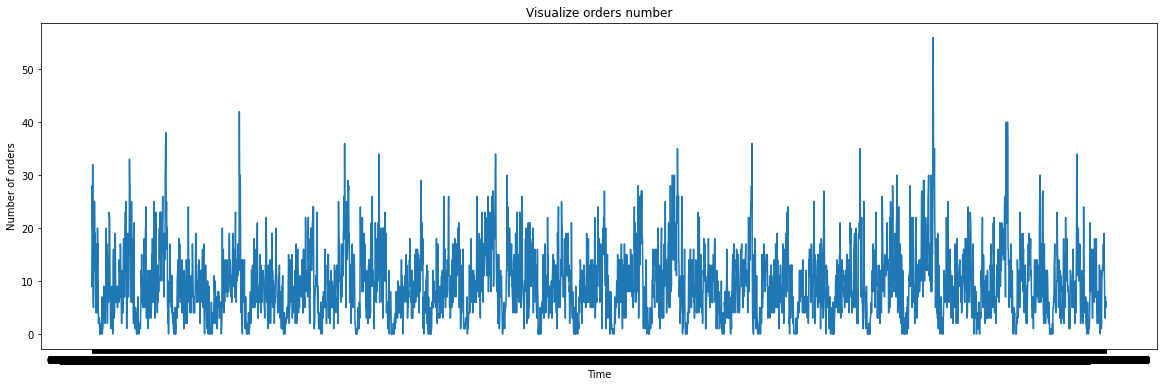

In [16]:
# Define plot space
viz=file.iloc[0:4000]
fig, ax = plt.subplots(figsize=(20, 6))

# Define x and y axes
ax.plot(viz.datetime, 
        viz['num_orders'])

# Set plot title and axes labels
ax.set(title = "Visualize orders number",
       xlabel = "Time",
       ylabel = "Number of orders")

plt.show()

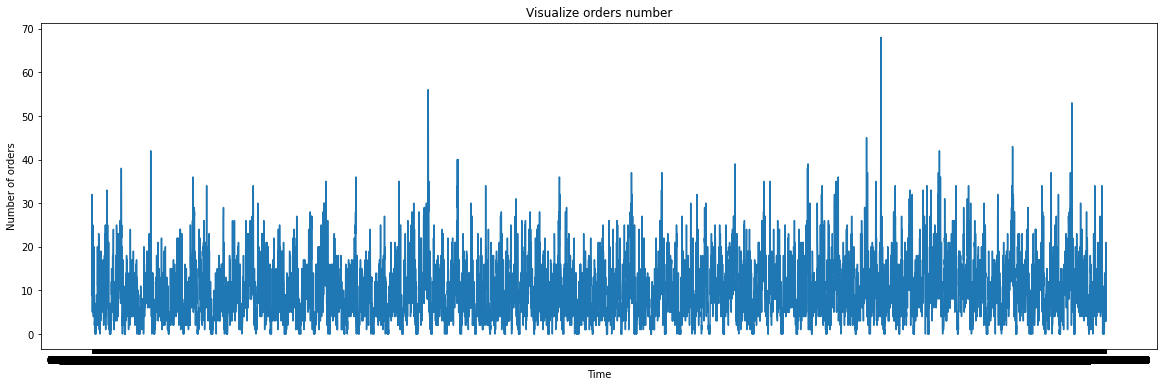

In [17]:
viz=file.iloc[0:10000]
fig, ax = plt.subplots(figsize=(20, 6))

# Define x and y axes
ax.plot(viz.datetime, 
        viz['num_orders'])

# Set plot title and axes labels
ax.set(title = "Visualize orders number",
       xlabel = "Time",
       ylabel = "Number of orders")

plt.show()

## Checking trend through statistical hypothesis

In [15]:
mk.original_test(file.iloc[0:10000]['num_orders'])

Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=10.671292648640614, Tau=0.07106644664466447, s=3552967.0, var_s=110853151099.66667, slope=0.00020868113522537563, intercept=7.956698664440735)

Test reveals that there is increasing trend for long time period

In [81]:
ts = file.copy()
ts=ts.set_index('datetime')
ts.index =  pd.to_datetime(ts.index)
#ts

,num_orders
datetime,
2018-01-03 00:00:00,9
2018-01-03 00:10:00,14
2018-01-03 00:20:00,28
2018-01-03 00:30:00,20
2018-01-03 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


## Converting 10 minutes resolutons to hourly resolution by summing 

## Hourly analysis

In [6]:
df=file.copy()

In [7]:
df['datetime']=df['datetime'].apply(lambda x: str(x[0:-3])+':00:00')

In [8]:
df_grouped=df.groupby('datetime')

In [9]:
df_grouped['num_orders'].agg(np.sum)

datetime
01/03/2018 00:00:00    124
01/03/2018 01:00:00     85
01/03/2018 02:00:00     71
01/03/2018 03:00:00     66
01/03/2018 04:00:00     43
                      ... 
31/08/2018 19:00:00    136
31/08/2018 20:00:00    154
31/08/2018 21:00:00    159
31/08/2018 22:00:00    223
31/08/2018 23:00:00    205
Name: num_orders, Length: 4416, dtype: int64

In [10]:
df_new=pd.DataFrame(df_grouped['num_orders'].agg(np.sum))

In [11]:
#df_new.to_excel('tet.xlsx')

### Decomposing time series into trend and seasonality

<Figure size 432x288 with 0 Axes>

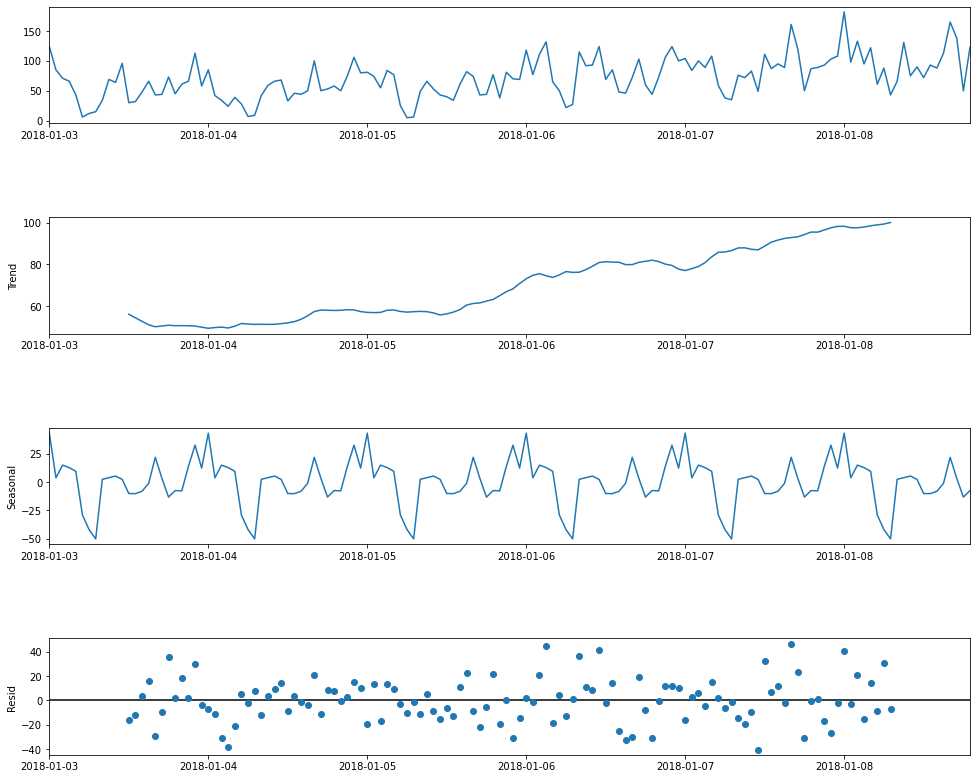

In [187]:
samp=df_new[0:140]
samp.index=pd.to_datetime(samp.index)
decompose_result_add = seasonal_decompose(samp.asfreq('H'), model="additive")
trend = decompose_result_add.trend
seasonal = decompose_result_add.seasonal
residual = decompose_result_add.resid
fig = plt.figure()  

#decompose_result_add.plot()
fig=decompose_result_add.plot()
fig.set_size_inches(15, 12)

In [49]:

#print(seasonal[0:20])

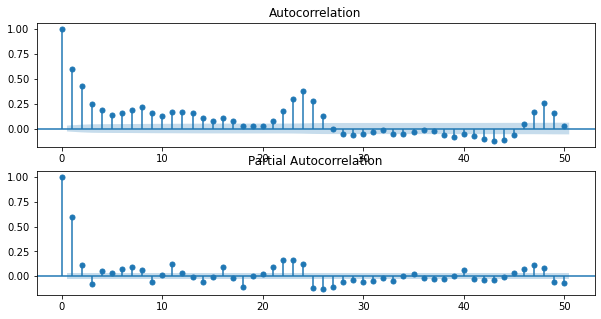

In [189]:
import statsmodels.api as sm
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(df_new, lags=50, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(df_new, lags=50, ax=ax[1])
plt.show()

In [190]:
first_diff = df_new.num_orders - df_new.num_orders.shift(1)
first_diff = first_diff.dropna(inplace = False)

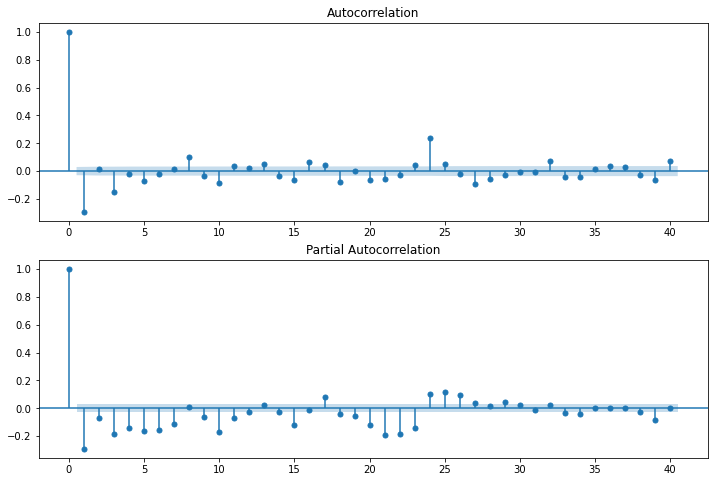

In [191]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)


## Statioanary 

In [147]:
result = adfuller(df_new)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -10.227432500170552
p-value: 5.132901448401154e-18
Critical Values:
	1%: -3.431842162413052
	5%: -2.8621993540813637
	10%: -2.567120978470452


p value is less than 0.05 for null hypothesis, so time series is stationary

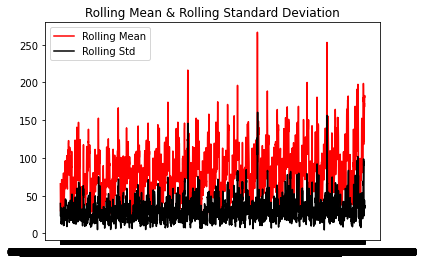

In [157]:
rolling_mean = df_new.rolling(window = 6).mean()
rolling_std = df_new.rolling(window = 6).std()
#plt.plot(ts, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

## SARIMAX model

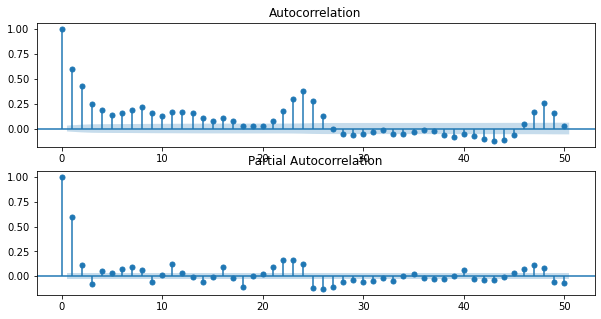

In [148]:
import statsmodels.api as sm
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(df_new, lags=50, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(df_new, lags=50, ax=ax[1])
plt.show()


In [13]:
import statsmodels.api as sm

C:\Users\Hamzah\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                           num_orders   No. Observations:                  200
Model:             SARIMAX(3, 1, 6)x(0, 0, [1], 24)   Log Likelihood               -1010.760
Date:                              Thu, 31 Mar 2022   AIC                           2043.520
Time:                                      16:43:46   BIC                           2079.747
Sample:                                           0   HQIC                          2058.182
                                              - 200                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0530      0.362     -0.146      0.884      -0.762       0.656
ar.L2         -0.14

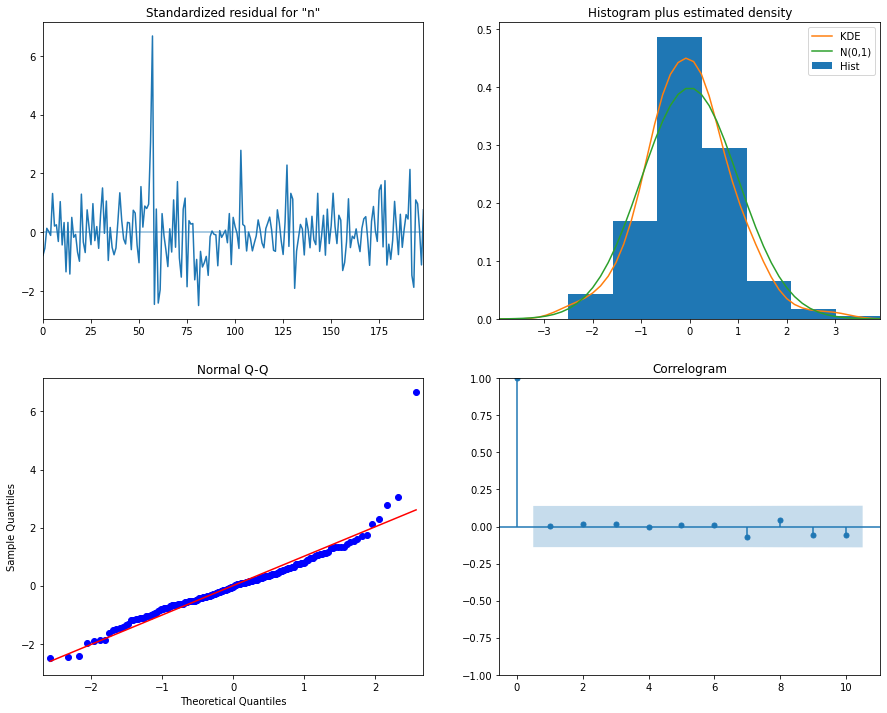

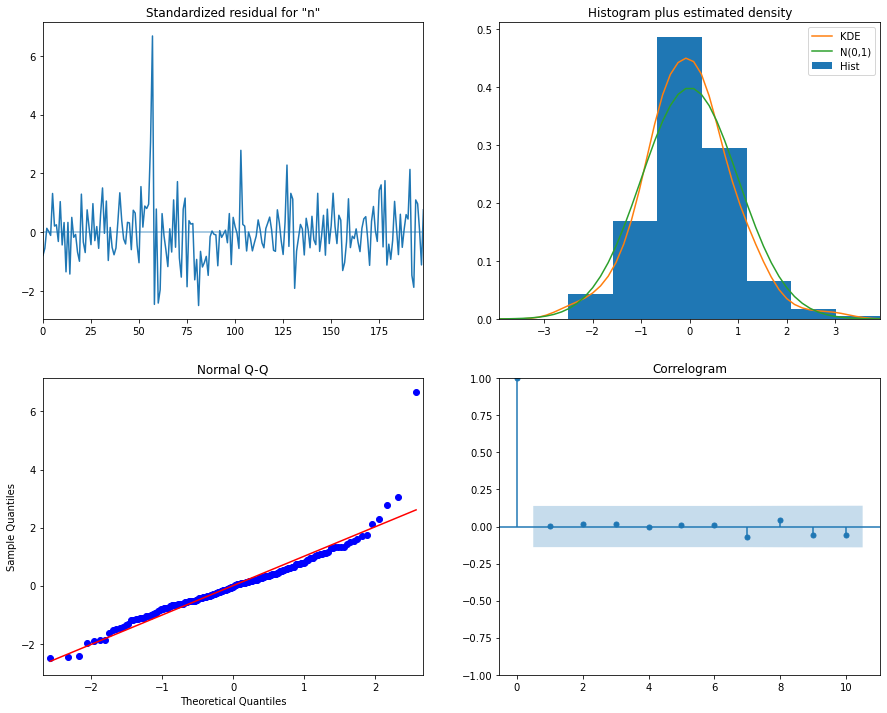

In [63]:
best_model = sm.tsa.statespace.SARIMAX(df_new[2800:3000], order=(3,1,6), seasonal_order=(0, 0, 1, 24), 
                                  enforce_stationarity=True, enforce_invertibility=True).fit()
    
print(best_model.summary())
best_model.plot_diagnostics(figsize=(15,12))


In [64]:
forecast_data = best_model.predict(3000, 3050)
actual_data=df_new[3000:3050]

print(error_rmse(np.asarray(actual_data),np.asarray(forecast_data)))

C:\Users\Hamzah\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


53.56477833869614


C:\Users\Hamzah\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\Hamzah\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\Hamzah\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\Hamzah\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                           num_orders   No. Observations:                  100
Model:             SARIMAX(3, 1, 6)x(0, 0, [1], 24)   Log Likelihood                -449.996
Date:                              Thu, 31 Mar 2022   AIC                            921.992
Time:                                      16:45:52   BIC                            950.539
Sample:                                  01-03-2018   HQIC                           933.542
                                       - 01-07-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7116     11.316     -0.063      0.950     -22.890      21.467
ar.L2         -0.47

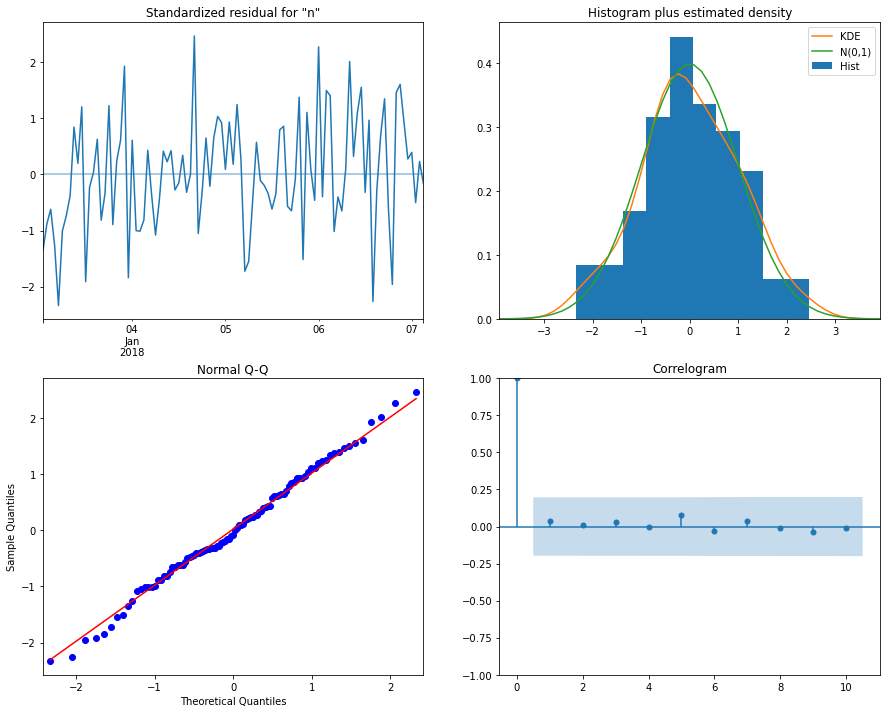

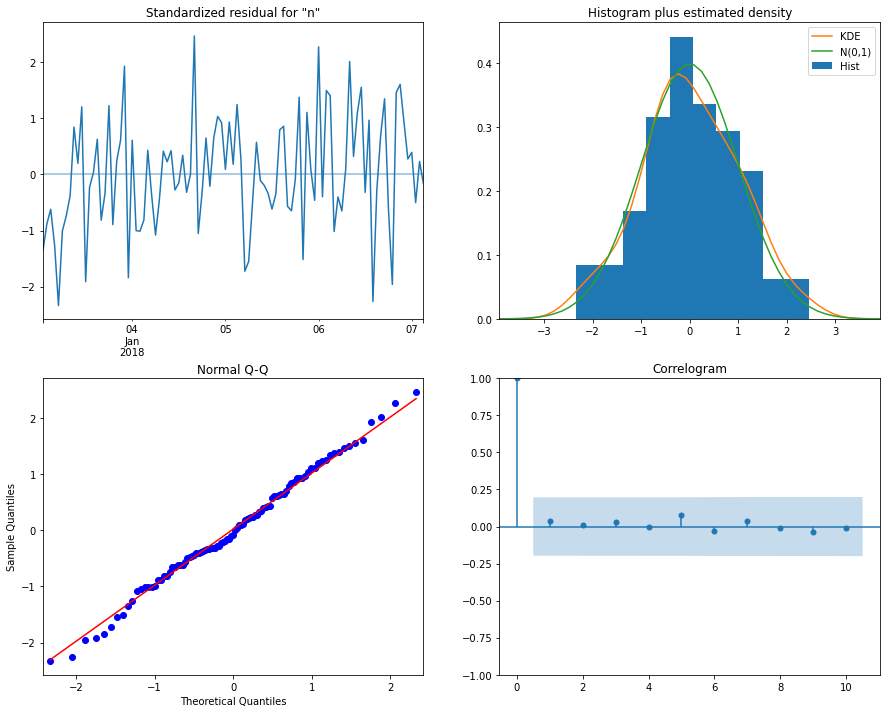

In [65]:
best_model = sm.tsa.statespace.SARIMAX(df_new[0:100], order=(3,1,6), seasonal_order=(0, 0, 1, 24), 
                                  enforce_stationarity=True, enforce_invertibility=True).fit()
    
print(best_model.summary())
best_model.plot_diagnostics(figsize=(15,12))

In [66]:
forecast_data = best_model.predict(100, 150)
actual_data=df_new[100:150]

print(error_rmse(np.asarray(actual_data),np.asarray(forecast_data)))

36.94126346551565


In [69]:
best_model = sm.tsa.statespace.SARIMAX(df_new[200:440], order=(3,1,5), seasonal_order=(0, 0, 1, 24), 
                                  enforce_stationarity=True, enforce_invertibility=True).fit()
    
print(best_model.summary())
#best_model.plot_diagnostics(figsize=(15,12))

C:\Users\Hamzah\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                           num_orders   No. Observations:                  240
Model:             SARIMAX(3, 1, 5)x(0, 0, [1], 24)   Log Likelihood               -1149.536
Date:                              Thu, 31 Mar 2022   AIC                           2319.071
Time:                                      16:47:47   BIC                           2353.836
Sample:                                           0   HQIC                          2333.080
                                              - 240                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8803      0.226      3.892      0.000       0.437       1.324
ar.L2         -1.07

In [70]:
forecast_data = best_model.predict(440, 500)
actual_data=df_new[440:500]

print(error_rmse(np.asarray(actual_data),np.asarray(forecast_data)))

33.50882002643232


C:\Users\Hamzah\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [79]:
best_model = sm.tsa.statespace.SARIMAX(df_new[200:440], order=(3,0,1), seasonal_order=(0, 0, 2, 24), 
                                  enforce_stationarity=True, enforce_invertibility=True).fit()
    
print(best_model.summary())
#best_model.plot_diagnostics(figsize=(15,12))
forecast_data = best_model.predict(440, 500)
actual_data=df_new[440:500]

print(error_rmse(np.asarray(actual_data),np.asarray(forecast_data)))


C:\Users\Hamzah\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                        
Dep. Variable:                              num_orders   No. Observations:                  240
Model:             SARIMAX(3, 0, 1)x(0, 0, [1, 2], 24)   Log Likelihood               -1156.784
Date:                                 Thu, 31 Mar 2022   AIC                           2327.567
Time:                                         16:50:44   BIC                           2351.932
Sample:                                              0   HQIC                          2337.385
                                                 - 240                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4995      0.066     22.765      0.000       1.370       1

C:\Users\Hamzah\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [95]:
best_model = sm.tsa.statespace.SARIMAX(df_new[200:600], order=(12,1,5), seasonal_order=(0, 0, 1, 24), 
                                  enforce_stationarity=True, enforce_invertibility=True).fit()
    
print(best_model.summary())
#best_model.plot_diagnostics(figsize=(15,12))
forecast_data = best_model.predict(600, 700)
actual_data=df_new[600:700]

print(error_rmse(np.asarray(actual_data),np.asarray(forecast_data)))


C:\Users\Hamzah\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                       SARIMAX Results                                       
Dep. Variable:                            num_orders   No. Observations:                  400
Model:             SARIMAX(12, 1, 5)x(0, 0, [1], 24)   Log Likelihood               -1908.026
Date:                               Thu, 31 Mar 2022   AIC                           3854.051
Time:                                       16:56:01   BIC                           3929.842
Sample:                                            0   HQIC                          3884.068
                                               - 400                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4945      0.068     -7.237      0.000      -0.628      -0.361
ar.L2      

C:\Users\Hamzah\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
